In [ ]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pprint import pprint
from scipy import stats
from sklearn import preprocessing
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from pandas_profiling import ProfileReport
import math

/usr/local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%matplotlib inline

In [3]:
TRAIN_PATH = "/workspace/data/predict_future_sales/sales_train.csv"

train_df = pd.read_csv(TRAIN_PATH)
train_df['item_sum'] = train_df['item_price'] * train_df['item_cnt_day']

# ざっくりとした情報の確認

In [4]:
print("データ構成", train_df.shape)
display(train_df.isnull().sum())

データ構成 (2935849, 7)


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
item_sum          0
dtype: int64

In [5]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_sum
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [6]:
print(f"ショップ数:{train_df['shop_id'].nunique()} アイテム数:{train_df['item_id'].nunique()}")
print(f"日数:{train_df['date'].nunique()} min:{train_df['date'].min()} max:{train_df['date'].max()}")

ショップ数:60 アイテム数:21807
日数:1034 min:01.01.2013 max:31.12.2014


## 日付を扱いやすいようにdatetimeに変換

In [7]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
train_df['month'] = train_df['date'].apply(lambda x: x.strftime("%Y%m"))

In [8]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_sum,month
0,2013-01-02,0,59,22154,999.00,1.0,999.00,201301
1,2013-01-03,0,25,2552,899.00,1.0,899.00,201301
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,201301
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,201301
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,201301


# 目的変数の確認

月別・ショップ別・アイテム別の購入数を予測する<br>
## **2013年1月〜2015年9月までのデータを使い、60店舗・2万点の次月売上を予測する**

In [9]:
pred_df = pd.DataFrame({"pred_num":train_df.groupby(["month", "shop_id", "item_id"])["item_cnt_day"].sum()})
pred_df = pred_df.reset_index()
pred_df.head()

,month,shop_id,item_id,pred_num
0,201301,0,32,6.0
1,201301,0,33,3.0
2,201301,0,35,1.0
3,201301,0,43,1.0
4,201301,0,51,2.0


In [10]:
print(f"ショップ数：{pred_df['shop_id'].nunique()}\nアイテム数：{pred_df['item_id'].nunique()}")

ショップ数：60
アイテム数：21807


# EDA

## 時系列プロット

### 全アイテムでの購買（上図）
短期の周期性はありそうで、トレンド的にも徐々に下降気味か。<br>
クリスマス前だけ異常に伸びているあたり、季節性もありそう

### 全アイテムの１年間（中図）
周期性は曜日だな！まだ見ていないけど多分土曜か日曜が最大か！<br>
そして、1年ではトレンドはほぼ分からない。（もちろん季節性も）<br>

### 今回の課題である月別の全アイテム（下図）
日別よりもはっきりとトレンドが減少傾向にあることがわかる<br>
また、12月だけ異常に売れているように季節性もはっきりしている

/tmp/ipykernel_22/2644597761.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(xlabel_list, rotation=90)


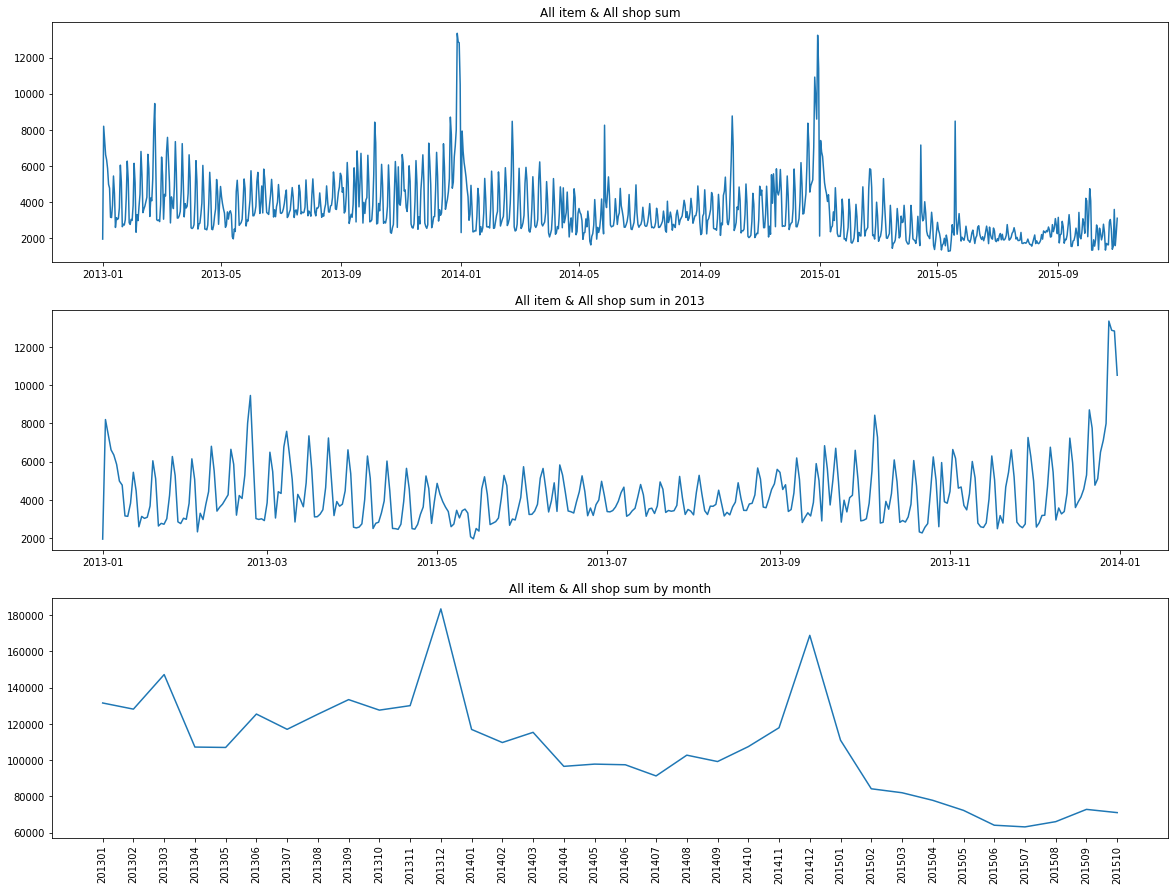

In [11]:
fig = plt.figure(figsize=(20,15))
ax = fig.subplots(3,1)


_df = pd.DataFrame({"sum":train_df.groupby("date")["item_cnt_day"].sum()})
_df = _df.reset_index()
ax[0].plot(_df['date'], _df['sum'])
ax[0].set_title("All item & All shop sum" )

_df = pd.DataFrame({"sum":train_df.query("date <= datetime.date(2013,12,31)").groupby("date")["item_cnt_day"].sum()})
_df = _df.reset_index()
ax[1].plot(_df['date'], _df['sum'])
ax[1].set_title("All item & All shop sum in 2013")

_df = pd.DataFrame({"sum":train_df.groupby("month")["item_cnt_day"].sum()})
_df = _df.reset_index()
xlabel_list = sorted(_df['month'].unique())
ax[2].plot(_df['month'], _df['sum'])
ax[2].set_title("All item & All shop sum by month" )
ax[2].set_xticklabels(xlabel_list, rotation=90)

# ax[3].plot(_df.rollint='')

plt.show()

## トレンド・周期性・季節性・残差に分けてみる

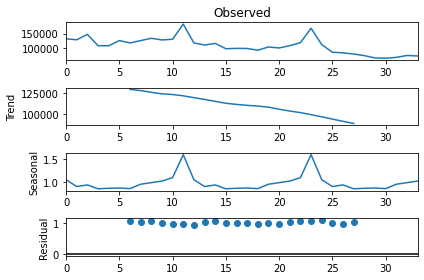

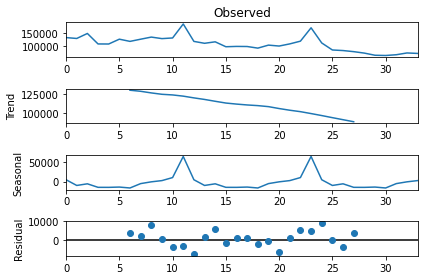

In [12]:
ts=train_df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

res = sm.tsa.seasonal_decompose(ts.values,period=12,model="multiplicative")
fig = res.plot()

res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
fig = res.plot()

## 商品別の売れ方

1商品だけダントツで売れている。<br>
この商品とそれ以外で注意した方が良さそう<br>

中央値は33個なので、ほぼ売れていない<br>
平均では167個なので、10日に1個くらいしか売れない　※過分散になっている<br>

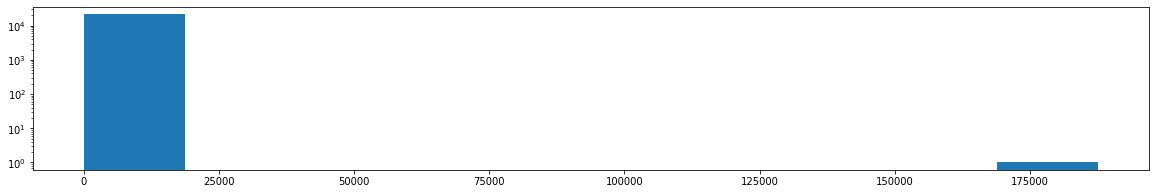

In [13]:
item_sum = pd.DataFrame({"sum":train_df.groupby("item_id")['item_cnt_day'].sum()})
item_sum = item_sum.reset_index().sort_values("sum")

plt.figure(figsize=(20,3))
plt.hist(item_sum['sum'], log=True)
plt.show()

In [14]:
print("最も売れている5商品")
display(item_sum.tail())

print("統計情報")
display(item_sum.describe())

最も売れている5商品


,item_id,sum
5717,5822,14515.0
17418,17717,15830.0
3654,3732,16642.0
2749,2808,17245.0
20602,20949,187642.0


統計情報


,item_id,sum
count,21807.000000,21807.00000
mean,11098.699271,167.29518
std,6397.059362,1366.22019
min,0.000000,-11.00000
25%,5551.500000,7.00000
50%,11105.000000,33.00000
75%,16647.500000,124.00000
max,22169.000000,187642.00000


## 店舗別の売れ方

売れている店舗はやはり2:8の法則っぽい<br>
ほとんどの店舗の売上合計より、少数店舗の売上の方が高い<br>
ローレンツ曲線を描くと、めちゃくちゃ不平等になる

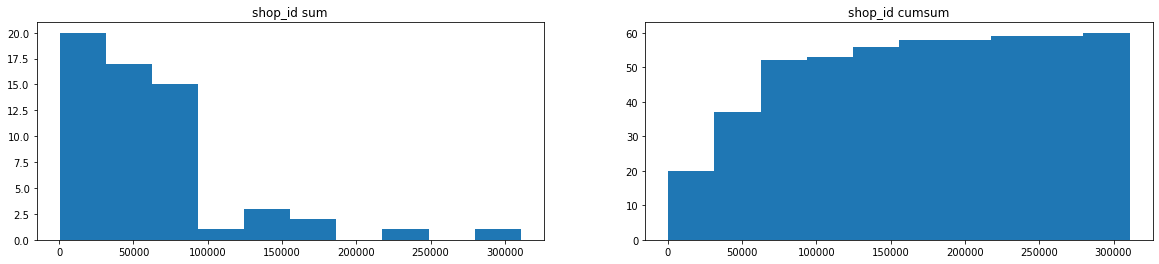

In [15]:
shop_sum = pd.DataFrame({"sum":train_df.groupby("shop_id")['item_cnt_day'].sum()})
shop_sum = shop_sum.reset_index().sort_values("sum")

fig = plt.figure(figsize=(20,4))
ax = fig.subplots(1,2)

ax[0].hist(shop_sum['sum'])
ax[0].set_title("shop_id sum")

ax[1].hist(shop_sum['sum'], cumulative=True)
ax[1].set_title("shop_id cumsum")

plt.show()

## 単価別の売れ方

販売単価にもかなりの幅がある。<br>
めちゃくちゃ単価が高い商品も存在する<br>

また、圧倒的に売れている商品は約５ドルと買いやすい金額になっていた

(array([2.1788e+04, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.95019079e+00, 3.08024552e+04, 6.15999602e+04, 9.23974651e+04,
        1.23194970e+05, 1.53992475e+05, 1.84789980e+05, 2.15587485e+05,
        2.46384990e+05, 2.77182495e+05, 3.07980000e+05]),
 <BarContainer object of 10 artists>)

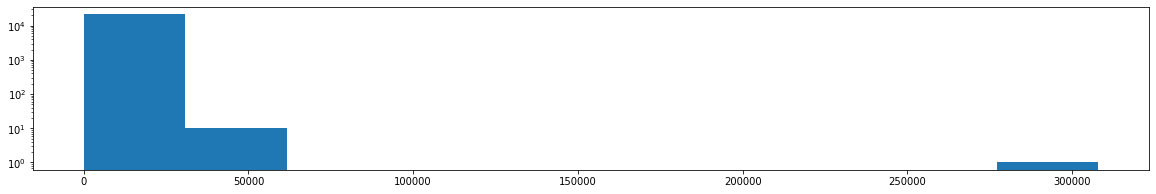

In [16]:
#　商品別単価のdf作成
price_sum = pd.DataFrame({"item_sum_allday":train_df.groupby("item_id")["item_sum"].sum()})
price_sum = price_sum.reset_index()
price_sum = pd.merge(price_sum, item_sum, on='item_id', how='inner')
price_sum = price_sum.query("sum >= 1")
price_sum['price_ave'] = price_sum['item_sum_allday'] / price_sum['sum']
price_sum = price_sum.sort_values("price_ave")


plt.figure(figsize=(20,3))
plt.hist(price_sum['price_ave'], log=True)

In [17]:
print("統計情報")
display(price_sum["price_ave"].describe())

print("="*50)
ave = round(price_sum.query("item_id == 20949")["price_ave"].unique()[0], 2)
print(f"最も売れている商品の平均金額：{ave}")

統計情報


count     21799.000000
mean        821.625867
std        2781.277858
min           4.950191
25%         186.000000
50%         321.754113
75%         849.000000
max      307980.000000
Name: price_ave, dtype: float64

最も売れている商品の平均金額：4.95


# 他情報をJoinしてみてみる

In [18]:
path = "/workspace/data/predict_future_sales/items.csv"
df = pd.read_csv(path)
train_df = pd.merge(train_df, df, on='item_id', how='left')

path = "/workspace/data/predict_future_sales/item_categories.csv"
df = pd.read_csv(path)
train_df = pd.merge(train_df, df, on='item_category_id', how='left')

In [19]:
print("アイテムカテゴリ数：",train_df['item_category_id'].nunique())

アイテムカテゴリ数： 84


In [20]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_sum,month,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,999.00,201301,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,899.00,201301,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,201301,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,201301,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,201301,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


# 単位根検定

<span style="font-size: 150%;">ADF検定にて実装</span><br>
帰無仮説が「単位根である」ため、定常性の判断がしやすい ＝　棄却されれば良い

<span style="font-size: 140%;">上図：ローデータの月次集計</span><br>
月別の元データでは棄却されなかったため、<span style="color: red;">非定常過程</span>である（まぁ、上のEDAを見ればトレンドあるし当然！）

<span style="font-size: 140%;">中図：1回差分データ</span><br>
1回差分であればP値が棄却されたため、<span style="color: red;">定常過程</span>である(ただ、明らかにまだ季節性が残っている）

<span style="font-size: 140%;">下図：1回差分＋季節性除外データ</span><br>
12回差分でもP値が棄却されたので、<span style="color: red;">定常過程</span>である（そして、きれいに残差っぽくなっている）

In [21]:
def test_stationarity(timeseries):
    """ 拡張AD検定にて定常過程の検定"""
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[1:2], index=['p-value'])
    print (dfoutput)

拡張AD検定 --------------------
ローデータの月次集計
p-value    0.142953
dtype: float64
１回差分データ　トレンド除去
p-value    1.686395e-25
dtype: float64
12回差分データ　季節性除去
p-value    0.016269
dtype: float64


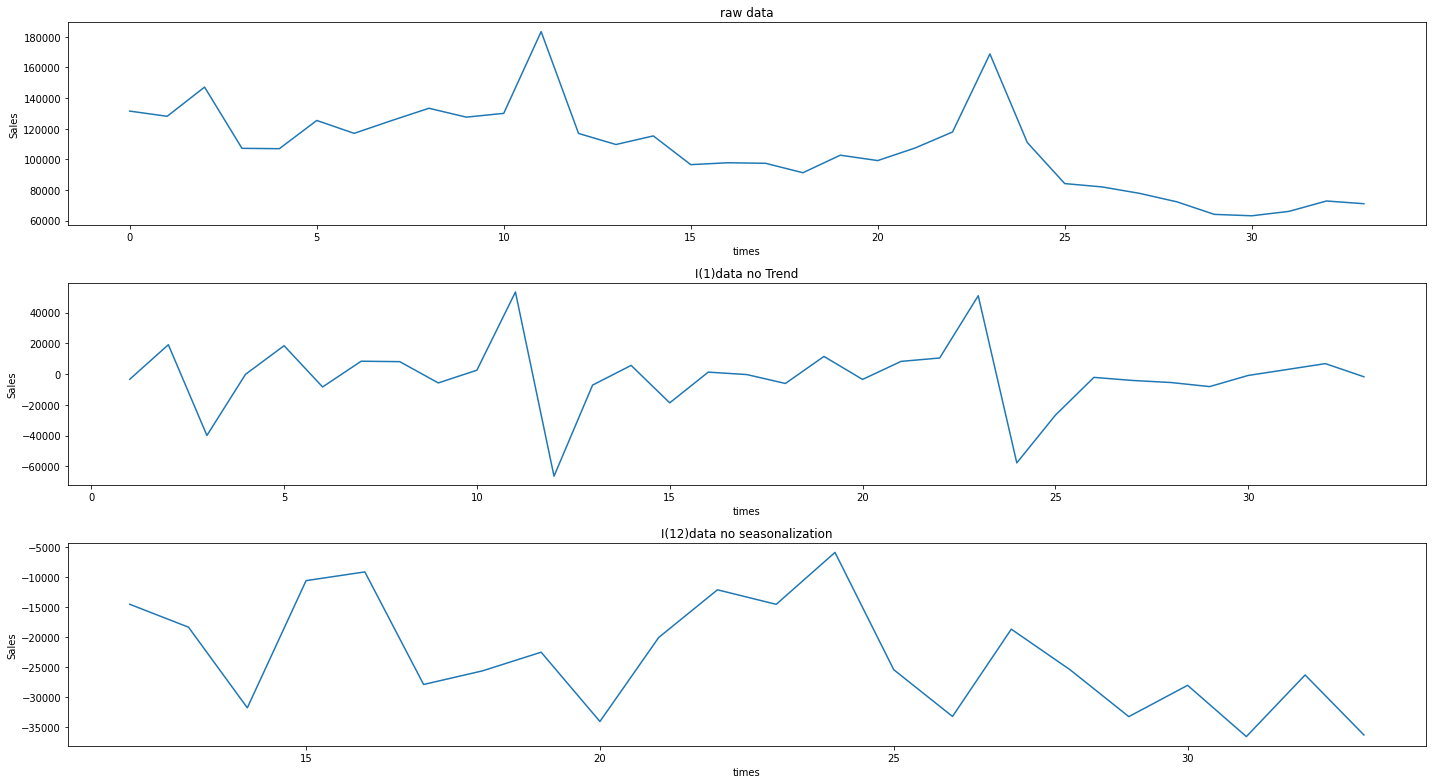

In [22]:
print("拡張AD検定", '-'*20)

# 元データの月別集計
ts=train_df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
print("ローデータの月次集計")
test_stationarity(ts)
print("="*50)

# 1回差分
print("１回差分データ　トレンド除去")
ts_diff = ts.diff().dropna()
test_stationarity(ts_diff)
print("="*50)

# 12回差分
print("12回差分データ　季節性除去")
ts_diff_12 = ts.diff(12).dropna()
test_stationarity(ts_diff_12)

fig = plt.figure(figsize=(20,11))
ax = fig.subplots(3,1)

ax[0].plot(ts.index, ts.values)
ax[1].plot(ts_diff.index, ts_diff.values)
ax[2].plot(ts_diff_12.index, ts_diff_12.values)

ax[0].set_title("raw data")
ax[1].set_title("I(1)data no Trend")
ax[2].set_title("I(12)data no seasonalization")

ax[0].set_xlabel("times")
ax[1].set_xlabel("times")
ax[2].set_xlabel("times")

ax[0].set_ylabel("Sales")
ax[1].set_ylabel("Sales")
ax[2].set_ylabel("Sales")

plt.tight_layout() 
plt.show()

# 自己相関・偏自己相関

右：自己相関　左：偏自己相関<br>

<span style="font-size: 140%;">上図：ローデータの月次集計</span><br>
両方とも1回前との相関が発生している。<br>
しかし、季節性は意外にもない。12月以外はそこまで季節性がないようだ<br>

<span style="font-size: 140%;">中図：1回差分データ</span><br>
１回前との差分は取り除けている。<br>
しかし、逆に季節性の偏自己相関がとんでもなく出ている<brt>

<span style="font-size: 140%;">下図：1回差分＋季節性除外データ</span><br>
<span style="color:red;">全ての相関が取り除けている！！！！</span>

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


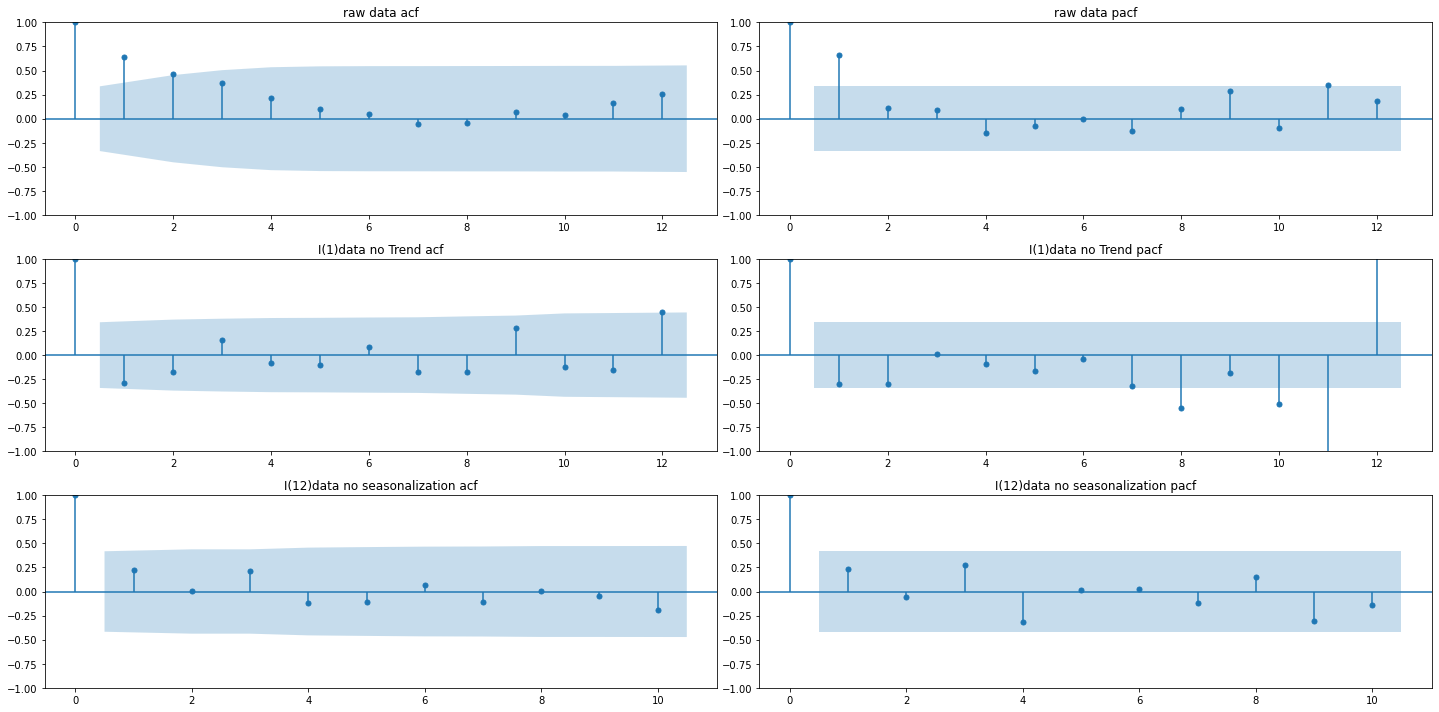

In [24]:
#  自己相関のグラフ
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

fig11 = sm.graphics.tsa.plot_acf(ts, lags=12, ax=ax1)
fig12 = sm.graphics.tsa.plot_pacf(ts, lags=12, ax=ax2)
fig21 = sm.graphics.tsa.plot_acf(ts_diff, lags=12, ax=ax3)
fig22 = sm.graphics.tsa.plot_pacf(ts_diff, lags=12, ax=ax4)
fig31 = sm.graphics.tsa.plot_acf(ts_diff_12, lags=10, ax=ax5)
fig32 = sm.graphics.tsa.plot_pacf(ts_diff_12, lags=10, ax=ax6)

ax1.set_title("raw data acf")
ax2.set_title("raw data pacf")
ax3.set_title("I(1)data no Trend acf")
ax4.set_title("I(1)data no Trend pacf")
ax5.set_title("I(12)data no seasonalization acf")
ax6.set_title("I(12)data no seasonalization pacf")

plt.tight_layout() 
plt.show()